In [41]:
# Standard library imports
import os
import time
import warnings
import random
import glob
import pickle
from pathlib import Path
from typing import Tuple, Dict, List
import numpy as np
import pandas as pd
import requests
import zipfile
import cv2
from PIL import Image
from skimage import io, transform
from skimage.feature import hog
from skimage import data, exposure
from skimage.color import rgb2gray
from skimage.transform import resize
from collections import Counter

# ML & utilities 
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

# Data visualization
import matplotlib.pyplot as plt
plt.ion()
# Reproducibility: set fixed seeds for python, numpy and tensorflow
SEED = 12345
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print('Seeds set to', SEED)


Seeds set to 12345


In [42]:
def load_pickle_image(file_path):
    with open(file_path, "rb") as f:         
        return pickle.load(f)                 

file_paths = []                              
for vol in range(1, 9):                      
    folder = f"archive/vol{vol:02d}"         
    file_paths += sorted(glob.glob(f"{folder}/*.pck"))  

print(f"Found {len(file_paths)} total image files")

Found 736 total image files


In [43]:
# Associate labels from metadata.csv to image file paths

meta = pd.read_csv("metadata.csv")
# Map filename -> original numeric label (0=Normal,1=Torn,2=Partially torn)
fn_to_label = dict(zip(meta['volumeFilename'], meta['aclDiagnosis']))
# Convert to binary: merge 'Partially torn' (2) into 'Torn' (1)
label_names = {0: 'Normal', 1: 'Torn'}

# Build mapping list (file_path, numeric_label, label_name_or_None)
mapped = []
for p in file_paths:
    fname = os.path.basename(p)
    orig = fn_to_label.get(fname, None)
    if orig is None:
        label = None
    else:
        if int(orig) == 2:
            label = 1
        else:
            label = int(orig)
    mapped.append((p, label, label_names.get(label) if label is not None else None))

# Summary
print("Label distribution (numeric):", Counter(l for _p, l, _n in mapped if l is not None))
print("Label distribution (names):", Counter(n for _p, l, n in mapped if n is not None))


Label distribution (numeric): Counter({0: 547, 1: 189})
Label distribution (names): Counter({'Normal': 547, 'Torn': 189})


Detected classes: [0, 1]
Preprocessing done — 389 items in 5.8s
Preprocessing done — 389 items in 5.8s
Saved preprocessed cache to cache/preprocessed.npz
Unique labels in dataset: [0 1]
SGD-SVM acc: 0.5769230769230769
SGD-LogReg acc: 0.5769230769230769

SGD-SVM classification report:

              precision    recall  f1-score   support

      Normal       0.61      0.50      0.55        40
        Torn       0.56      0.66      0.60        38

    accuracy                           0.58        78
   macro avg       0.58      0.58      0.58        78
weighted avg       0.58      0.58      0.57        78


SGD-LogReg classification report:

              precision    recall  f1-score   support

      Normal       0.56      0.78      0.65        40
        Torn       0.61      0.37      0.46        38

    accuracy                           0.58        78
   macro avg       0.59      0.57      0.56        78
weighted avg       0.59      0.58      0.56        78

Image-train class counts

/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: Runtim

20/20 - 2s - 116ms/step - accuracy: 0.4791 - loss: 1.0214 - val_accuracy: 0.5128 - val_loss: 0.6929
Epoch 2/100
Epoch 2/100
20/20 - 0s - 21ms/step - accuracy: 0.5370 - loss: 1.0284 - val_accuracy: 0.5128 - val_loss: 0.6928
Epoch 3/100
20/20 - 0s - 21ms/step - accuracy: 0.5370 - loss: 1.0284 - val_accuracy: 0.5128 - val_loss: 0.6928
Epoch 3/100
20/20 - 0s - 21ms/step - accuracy: 0.4952 - loss: 0.9221 - val_accuracy: 0.5128 - val_loss: 0.6928
Epoch 4/100
20/20 - 0s - 21ms/step - accuracy: 0.4952 - loss: 0.9221 - val_accuracy: 0.5128 - val_loss: 0.6928
Epoch 4/100
20/20 - 1s - 25ms/step - accuracy: 0.5434 - loss: 0.9773 - val_accuracy: 0.5128 - val_loss: 0.6928
Epoch 5/100
20/20 - 1s - 25ms/step - accuracy: 0.5434 - loss: 0.9773 - val_accuracy: 0.5128 - val_loss: 0.6928
Epoch 5/100
20/20 - 0s - 21ms/step - accuracy: 0.5820 - loss: 0.9314 - val_accuracy: 0.5128 - val_loss: 0.6928
Epoch 6/100
20/20 - 0s - 21ms/step - accuracy: 0.5820 - loss: 0.9314 - val_accuracy: 0.5128 - val_loss: 0.6928


Text(0.5, 1.0, 'CNN accuracy')

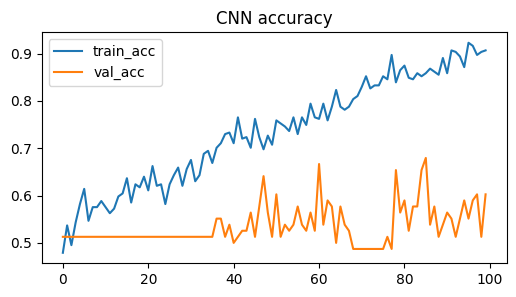

In [ ]:
# Simplified preprocessing + training for binary classification (Torn vs Normal)
MAX_SAMPLES = 400
IMG_SIZE = (64, 64)
hog_params = dict(orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2))
AUG_PER_SAMPLE = 0  # no offline augmentations

# Build per-label lists
paths_by_label = {}
for file_path, label, _name in mapped:
    if label is None:
        continue
    paths_by_label.setdefault(label, []).append(file_path)

class_labels = sorted(paths_by_label.keys())
num_classes = len(class_labels)
print('Detected classes:', class_labels)

# Determine samples per class target (balanced)
samples_per_class_target = max(1, MAX_SAMPLES // max(1, num_classes))

# Prepare cache
cache_dir = Path('cache')
cache_dir.mkdir(exist_ok=True)
cache_path = cache_dir / 'preprocessed.npz'
rng = random.Random(SEED)
np_rng = np.random.RandomState(SEED)

if cache_path.exists():
    print('Loading preprocessed data from', cache_path)
    data = np.load(cache_path, allow_pickle=True)
    X_hog = data['X_hog']
    X_images = data['X_images']
    y_labels = data['y_labels']
else:
    hog_features_list = []
    image_tensors_list = []
    labels_list = []
    t_start = time.time()
    for label in class_labels:
        file_paths_for_label = paths_by_label[label]
        if len(file_paths_for_label) == 0:
            continue
        n_take = min(len(file_paths_for_label), samples_per_class_target)
        # deterministic sampling
        chosen = rng.sample(list(file_paths_for_label), n_take) if n_take <= len(file_paths_for_label) else [rng.choice(list(file_paths_for_label)) for _ in range(n_take)]
        for chosen_path in chosen:
            volume = load_pickle_image(chosen_path)
            volume_arr = np.asarray(volume)

            # Build raw input for CNN: stack central slice +/- 1 as channels (3-channel input)
            if volume_arr.ndim == 3 and volume_arr.shape[0] >= 3:
                center_idx = volume_arr.shape[0] // 2
                idxs = [max(0, center_idx - 1), center_idx, min(volume_arr.shape[0] - 1, center_idx + 1)]
                channels = []
                for si in idxs:
                    s = volume_arr[si]
                    if s.ndim == 3:
                        s = rgb2gray(s)
                    s_res = resize(s, IMG_SIZE, anti_aliasing=True)
                    channels.append(s_res.astype(np.float32))
                slice_resized = channels[1]
                cnn_img = np.stack(channels, axis=-1)
            else:
                # single-slice volume or unexpected shape: use the single slice replicated across 3 channels
                slice_resized = volume_arr[volume_arr.shape[0] // 2] if volume_arr.ndim == 3 else volume_arr
                if slice_resized.ndim == 3:
                    slice_resized = rgb2gray(slice_resized)
                slice_resized = resize(slice_resized, IMG_SIZE, anti_aliasing=True)
                cnn_img = np.stack([slice_resized.astype(np.float32)] * 3, axis=-1)

            # HOG computed on the central single-channel slice (keeps classical pipeline)
            hog_descriptor = hog((slice_resized * 255).astype(np.uint8), orientations=hog_params['orientations'], pixels_per_cell=hog_params['pixels_per_cell'], cells_per_block=hog_params['cells_per_block'], visualize=False, feature_vector=True)
            hog_features_list.append(hog_descriptor)

            # Save CNN input as 3-channel float32 in 0..1 range
            image_tensors_list.append(cnn_img)
            labels_list.append(label)
    t_end = time.time()
    print(f'Preprocessing done — {len(hog_features_list)} items in {t_end-t_start:.1f}s')
    # Truncate to MAX_SAMPLES deterministically (keep first N)
    if len(hog_features_list) > MAX_SAMPLES:
        hog_features_list = hog_features_list[:MAX_SAMPLES]
        image_tensors_list = image_tensors_list[:MAX_SAMPLES]
        labels_list = labels_list[:MAX_SAMPLES]
    X_hog = np.vstack(hog_features_list)
    y_labels = np.array(labels_list)
    X_images = np.stack(image_tensors_list)
    # Save deterministic preprocessed arrays
    np.savez_compressed(cache_path, X_hog=X_hog, X_images=X_images, y_labels=y_labels)
    print('Saved preprocessed cache to', cache_path)

# Binary labels: ensure values are 0/1
unique_labels = np.unique(y_labels)
print('Unique labels in dataset:', unique_labels)

# Create one fixed train/test split (re-used by all models). Use SEED for determinism
X_hog_train, X_hog_test, y_hog_train, y_hog_test = train_test_split(X_hog, y_labels, test_size=0.2, stratify=y_labels, random_state=SEED)
# Build matching image train/val split indices deterministically
idx_all = np.arange(len(y_labels))
_, idx_test = train_test_split(idx_all, test_size=0.2, stratify=y_labels, random_state=SEED)
idx_train = np.setdiff1d(idx_all, idx_test)
X_images_train = X_images[idx_train]
X_images_val = X_images[idx_test]
y_images_train = y_labels[idx_train]
y_images_val = y_labels[idx_test]

# Train simple linear SGD models on HOG (deterministic)
epochs = 10
sgd_svm = SGDClassifier(loss='hinge', random_state=SEED)
for epoch in range(epochs):
    sgd_svm.partial_fit(X_hog_train, y_hog_train, classes=np.unique(y_hog_train))

sgd_logr = SGDClassifier(loss='log_loss', random_state=SEED)
for epoch in range(epochs):
    sgd_logr.partial_fit(X_hog_train, y_hog_train, classes=np.unique(y_hog_train))

print('SGD-SVM acc:', accuracy_score(y_hog_test, sgd_svm.predict(X_hog_test)))
print('SGD-LogReg acc:', accuracy_score(y_hog_test, sgd_logr.predict(X_hog_test)))

# Classification reports for SGD models (binary)
from sklearn.metrics import classification_report
labels_sorted = sorted(np.unique(y_hog_test))
label_names_for_report = [label_names.get(int(i), str(int(i))) for i in labels_sorted]
print('\nSGD-SVM classification report:\n')
print(classification_report(y_hog_test, sgd_svm.predict(X_hog_test), labels=labels_sorted, target_names=label_names_for_report))
print('\nSGD-LogReg classification report:\n')
print(classification_report(y_hog_test, sgd_logr.predict(X_hog_test), labels=labels_sorted, target_names=label_names_for_report))

# CNN: use a denser model for binary classification (3-channel raw input)
X_images_train = np.clip(X_images_train, 0.0, 1.0)
X_images_val = np.clip(X_images_val, 0.0, 1.0)

# Print image-train class counts (no oversampling)
unique, counts = np.unique(y_images_train, return_counts=True)
print('Image-train class counts:', dict(zip(unique.astype(int).tolist(), counts.tolist())))

class_weight_dict = None

n_classes = 2
model = models.Sequential([
    layers.Input(shape=X_images_train.shape[1:]),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax'),
])
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print('\nTraining CNN (no early stopping, denser model)...')
# Train without EarlyStopping callback
history = model.fit(X_images_train, y_images_train, epochs=100, batch_size=16, validation_data=(X_images_val, y_images_val), verbose=2, class_weight=class_weight_dict)
loss, acc = model.evaluate(X_images_val, y_images_val, verbose=0)
print('\nCNN validation acc:', acc)

# Classification report for CNN (binary) + confusion matrix and sample probs for diagnosis
y_pred_cnn = np.argmax(model.predict(X_images_val), axis=1)
labels_sorted_img = sorted(np.unique(y_images_val))
label_names_for_report_img = [label_names.get(int(i), str(int(i))) for i in labels_sorted_img]
print('\nCNN classification report:\n')
print(classification_report(y_images_val, y_pred_cnn, labels=labels_sorted_img, target_names=label_names_for_report_img))

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_images_val, y_pred_cnn, labels=labels_sorted_img)
print('Confusion matrix (rows=true, cols=pred):\n', cm)

# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.legend(); plt.title('CNN accuracy')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Model comparison:
     model  accuracy  precision   recall  f1_score
   SGD-SVM  0.576923   0.555556 0.657895  0.602410
SGD-LogReg  0.576923   0.608696 0.368421  0.459016
       CNN  0.602564   0.666667 0.368421  0.474576

Model comparison:
     model  accuracy  precision   recall  f1_score
   SGD-SVM  0.576923   0.555556 0.657895  0.602410
SGD-LogReg  0.576923   0.608696 0.368421  0.459016
       CNN  0.602564   0.666667 0.368421  0.474576


/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/neel/Documents/GitHub/ACLInjuryDetection/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: Runtim

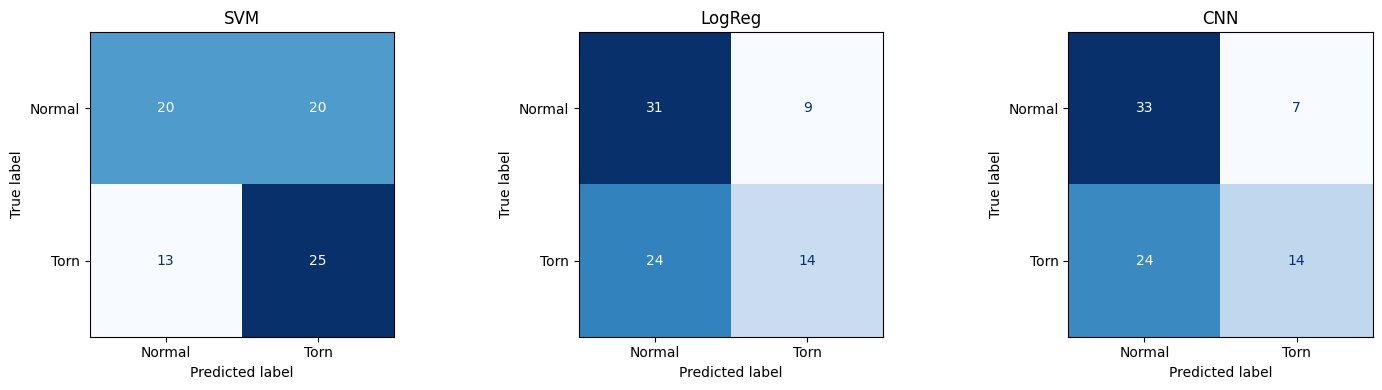

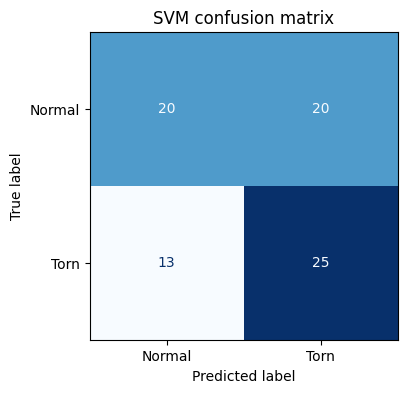

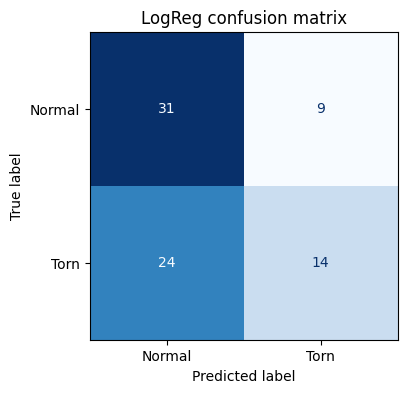

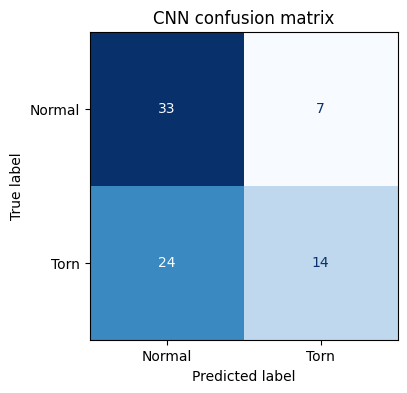

In [47]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predictions for each model
y_pred_svm = sgd_svm.predict(X_hog_test)
y_pred_logr = sgd_logr.predict(X_hog_test)
y_pred_cnn = np.argmax(model.predict(X_images_val), axis=1)

def _metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    return acc, prec, rec, f1

acc_svm, prec_svm, rec_svm, f1_svm = _metrics(y_hog_test, y_pred_svm)
acc_logr, prec_logr, rec_logr, f1_logr = _metrics(y_hog_test, y_pred_logr)
acc_cnn, prec_cnn, rec_cnn, f1_cnn = _metrics(y_images_val, y_pred_cnn)

results_df = pd.DataFrame({
    'model': ['SGD-SVM', 'SGD-LogReg', 'CNN'],
    'accuracy': [acc_svm, acc_logr, acc_cnn],
    'precision': [prec_svm, prec_logr, prec_cnn],
    'recall': [rec_svm, rec_logr, rec_cnn],
    'f1_score': [f1_svm, f1_logr, f1_cnn],
})
print('\nModel comparison:')
print(results_df.to_string(index=False))

# Plot confusion matrices side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
models_info = [('SVM', y_hog_test, y_pred_svm), ('LogReg', y_hog_test, y_pred_logr), ('CNN', y_images_val, y_pred_cnn)]
for ax, (name, y_true, y_pred) in zip(axes, models_info):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_names[0], label_names[1]])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(name)
plt.tight_layout()

# Plot each confusion matrix in its own separate figure (do not save)
models_info_for_plot = [('SVM', y_hog_test, y_pred_svm), ('LogReg', y_hog_test, y_pred_logr), ('CNN', y_images_val, y_pred_cnn)]
for name, y_true, y_pred in models_info_for_plot:
    cm_single = confusion_matrix(y_true, y_pred, labels=[0, 1])
    fig_single, ax_single = plt.subplots(figsize=(4, 4))
    disp_single = ConfusionMatrixDisplay(confusion_matrix=cm_single, display_labels=[label_names[0], label_names[1]])
    disp_single.plot(ax=ax_single, cmap='Blues', colorbar=False)
    ax_single.set_title(f'{name} confusion matrix')
    plt.show()
